In [ ]:
!pip install torch lerobot

In [ ]:
!pip install lerobot.data

## Training

In [ ]:
# Add parent directory to path to import train module
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
from train import train

print("\nStarting training process...")
print("Note: We'll use a public dataset for training as our sample is too small")

# Create a temporary directory for training output
train_output_dir = Path('model_output')

print(f"Training output will be saved to: {train_output_dir}")

train(output_dir=str(train_output_dir), dataset_id="ISdept/piper_arm")

## Prepare dataset

In [ ]:
# Import necessary modules
import sys
from pathlib import Path
import json
import re

# Add the src directory to the path so we can import prepare_dataset
from data_processing.prepare_dataset import process_session, create_tasks_parquet, create_episodes_parquet_index, update_total_frames_from_episodes, compute_and_save_dataset_stats
from data_processing.episode_data import EpisodeData, CameraData

# --- CONFIGURATION ---
ROOT_FOLDER = Path("data/piper_training_data/")  # Root folder containing episode subfolders
OUTPUT_FOLDER = Path("output/")  # Output folder for processed dataset
REPO_ID = "ISDept/piper_arm"  # Your desired Hugging Face repo ID
# ---------------------

def find_episode_folders(root_folder):
    """Find all episode folders with naming convention episode1, episode2, etc."""
    episode_folders = []
    pattern = re.compile(r'^episode(\d+)$', re.IGNORECASE)
    
    for item in root_folder.iterdir():
        if item.is_dir():
            match = pattern.match(item.name)
            if match:
                episode_folders.append((item, int(match.group(1))))
    
    # Sort by episode number
    episode_folders.sort(key=lambda x: x[1])
    return episode_folders

def find_json_and_videos(episode_folder):
    """Find JSON file and video files in the episode folder."""
    json_files = list(episode_folder.glob("*.json"))
    if not json_files:
        raise FileNotFoundError(f"No JSON file found in {episode_folder}")
    if len(json_files) > 1:
        print(f"Warning: Multiple JSON files found in {episode_folder}, using {json_files[0]}")
    
    json_path = json_files[0]
    
    # Find video files (assuming common video extensions)
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv']
    video_files = []
    for ext in video_extensions:
        video_files.extend(episode_folder.glob(f"*{ext}"))
    
    return json_path, video_files

def get_camera_name_from_video_path(video_path):
    """Determine camera name based on video filename content."""
    filename = video_path.stem.lower()
    if 'rgb' in filename:
        return 'rgb'
    elif 'depth' in filename:
        return 'depth'
    elif 'gripper' in filename:
        return 'gripper'
    else:
        # Fallback: use the last part of filename after underscore
        return video_path.stem.split('_')[-1]
      
def process_episode_folder(episode_folder, episode_idx, global_index_offset, last_frames_to_chop):
    """Process a single episode folder."""
    json_path, video_files = find_json_and_videos(episode_folder)
    
    # Create CameraData objects from video files
    cameras_list = []
    for video_path in video_files:
        # Extract camera name from filename (you might want to customize this logic)
        
        camera_name = get_camera_name_from_video_path(video_path)
        cameras_list.append(CameraData(video_path=str(video_path), camera=camera_name))
    
    episode_data = EpisodeData(
        joint_data_json_path=str(json_path), 
        episode_index=episode_idx, 
        fps=10, 
        global_index_offset=global_index_offset, 
        cameras=cameras_list,
        folder = episode_folder
    )
    
    # Process the first episode differently to create initial files
    is_first_episode = (episode_idx == 1)
    num_of_frames = process_session(episode_data, OUTPUT_FOLDER, is_first_episode, last_frames_to_chop)
    episode_data.num_of_frames = num_of_frames
    return episode_data

def main():
    # Find all episode folders
    episode_folders = find_episode_folders(ROOT_FOLDER)
    
    if not episode_folders:
        print(f"No episode folders found in {ROOT_FOLDER}")
        return
    
    print(f"Found {len(episode_folders)} episode folders")
    
    last_frames_to_chop = 10
    global_index_offset = 0
    all_episodes_data = []
    
    # Process each episode folder
    for episode_folder, episode_idx in episode_folders:
                
        try:
            episode_data = process_episode_folder(episode_folder, episode_idx, global_index_offset, last_frames_to_chop)
            all_episodes_data.append(episode_data)
            
            # Update global index offset for the next episode
            global_index_offset += episode_data.num_of_frames
            #global_index_offset -= last_frames_to_chop
            
            
        except Exception as e:
            print(f"Error processing episode {episode_idx}: {e}")
            continue
    
    # Create final output files after processing all episodes
    if all_episodes_data:
        # Only create tasks parquet for the first episode
        create_tasks_parquet(OUTPUT_FOLDER, 'pick_and_place')
        
        # Create episodes parquet index for all episodes
        for _, episode_idx in episode_folders:
            print('Handling index for episode:', episode_idx)
            create_episodes_parquet_index(OUTPUT_FOLDER, episode_idx)
        
        update_total_frames_from_episodes(OUTPUT_FOLDER)
        
        compute_and_save_dataset_stats(OUTPUT_FOLDER)
        
    else:
        print("No episodes were successfully processed")

if __name__ == "__main__":
    main()


/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 45 episode folders
Processing episode 1: episode1
Processed 100/219 images
Processed 200/219 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1288.57ba/s]

Successfully processed episode 1
Processing episode 2: episode2


Processed 100/199 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1418.43ba/s]


Successfully processed episode 2
Processing episode 3: episode3
Processed 100/233 images
Processed 200/233 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1255.03ba/s]

Successfully processed episode 3
Processing episode 4: episode4


Processed 100/198 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1052.79ba/s]


Successfully processed episode 4
Processing episode 5: episode5
Processed 100/236 images
Processed 200/236 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 734.17ba/s]


Successfully processed episode 5
Processing episode 6: episode6
Processed 100/226 images
Processed 200/226 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 876.55ba/s]

Successfully processed episode 6
Processing episode 7: episode7


Processed 100/154 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 786.19ba/s]


Successfully processed episode 7
Processing episode 8: episode8
Processed 100/217 images
Processed 200/217 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 688.27ba/s]

Successfully processed episode 8
Processing episode 9: episode9


Processed 100/221 images
Processed 200/221 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 716.85ba/s]

Successfully processed episode 9
Processing episode 10: episode10


Processed 100/187 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 636.08ba/s]


Successfully processed episode 10
Processing episode 11: episode11
Processed 100/215 images
Processed 200/215 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 566.57ba/s]

Successfully processed episode 11
Processing episode 12: episode12


Processed 100/208 images
Processed 200/208 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 500.04ba/s]

Successfully processed episode 12
Processing episode 13: episode13


Processed 100/217 images
Processed 200/217 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 523.83ba/s]

Successfully processed episode 13
Processing episode 14: episode14


Processed 100/197 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 496.96ba/s]


Successfully processed episode 14
Processing episode 15: episode15
Processed 100/171 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 363.74ba/s]


Successfully processed episode 15
Processing episode 16: episode16
Processed 100/173 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 377.25ba/s]


Successfully processed episode 16
Processing episode 17: episode17
Processed 100/238 images
Processed 200/238 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 389.41ba/s]

Successfully processed episode 17
Processing episode 18: episode18


Processed 100/171 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 362.08ba/s]


Successfully processed episode 18
Processing episode 19: episode19
Processed 100/229 images
Processed 200/229 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 378.07ba/s]

Successfully processed episode 19
Processing episode 20: episode20


Processed 100/203 images
Processed 200/203 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1709.87ba/s]

Successfully processed episode 20
Processing episode 21: episode21


Processed 100/221 images
Processed 200/221 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1562.71ba/s]

Successfully processed episode 21
Processing episode 22: episode22


Processed 100/158 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1602.71ba/s]


Successfully processed episode 22
Processing episode 23: episode23
Processed 100/162 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1364.45ba/s]


Successfully processed episode 23
Processing episode 24: episode24
Processed 100/186 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1053.85ba/s]


Successfully processed episode 24
Processing episode 25: episode25
Processed 100/149 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1060.51ba/s]


Successfully processed episode 25
Processing episode 26: episode26
Processed 100/167 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 809.87ba/s]


Successfully processed episode 26
Processing episode 27: episode27
Processed 100/173 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1708.47ba/s]


Successfully processed episode 27
Processing episode 28: episode28
Processed 100/191 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1461.94ba/s]


Successfully processed episode 28
Processing episode 29: episode29
Processed 100/133 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1340.89ba/s]

Successfully processed episode 29
Processing episode 30: episode30


Processed 100/128 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 876.37ba/s]

Successfully processed episode 30
Processing episode 31: episode31


Processed 100/162 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 872.72ba/s]


Successfully processed episode 31
Processing episode 32: episode32
Processed 100/190 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 877.10ba/s]


Successfully processed episode 32
Processing episode 33: episode33
Processed 100/152 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 720.92ba/s]


Successfully processed episode 33
Processing episode 34: episode34
Processed 100/133 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 903.94ba/s]

Successfully processed episode 34
Processing episode 35: episode35


Processed 100/142 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 711.74ba/s]

Successfully processed episode 35
Processing episode 36: episode36


Processed 100/139 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 732.12ba/s]

Successfully processed episode 36
Processing episode 37: episode37


Processed 100/133 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 740.78ba/s]

Successfully processed episode 37
Processing episode 38: episode38


Processed 100/160 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 675.30ba/s]


Successfully processed episode 38
Processing episode 39: episode39
Processed 100/157 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 651.49ba/s]


Successfully processed episode 39
Processing episode 40: episode40
Processed 100/158 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 434.78ba/s]


Successfully processed episode 40
Processing episode 41: episode41
Processed 100/157 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 620.00ba/s]


Successfully processed episode 41
Processing episode 42: episode42
Processed 100/148 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 459.35ba/s]


Successfully processed episode 42
Processing episode 43: episode43
Processed 100/122 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 539.39ba/s]

Successfully processed episode 43
Processing episode 44: episode44


Processed 100/124 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 549.50ba/s]

Successfully processed episode 44
Processing episode 45: episode45


Processed 100/151 images


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 425.13ba/s]
/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/compute_stats.py:154: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, _ = np.histogram(batch[:, i], bins=self._bin_edges[i])
/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/compute_stats.py:154: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, _ = np.histogram(batch[:, i], bins=self._bin_edges[i])
/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/compute_stats.py:154: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, _ = np.histogram(batch[:, i], bins=self._bin_edges[i])
/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/compute_stats.py:154: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'>

Successfully processed episode 45
Handling index for episode: 1
Handling index for episode: 2
Handling index for episode: 3
Handling index for episode: 4
Handling index for episode: 5
Handling index for episode: 6
Handling index for episode: 7
Handling index for episode: 8
Handling index for episode: 9
Handling index for episode: 10
Handling index for episode: 11
Handling index for episode: 12
Handling index for episode: 13
Handling index for episode: 14
Handling index for episode: 15
Handling index for episode: 16
Handling index for episode: 17
Handling index for episode: 18
Handling index for episode: 19
Handling index for episode: 20
Handling index for episode: 21
Handling index for episode: 22
Handling index for episode: 23
Handling index for episode: 24
Handling index for episode: 25
Handling index for episode: 26
Handling index for episode: 27
Handling index for episode: 28
Handling index for episode: 29
Handling index for episode: 30
Handling index for episode: 31
Handling index

/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/compute_stats.py:154: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, _ = np.histogram(batch[:, i], bins=self._bin_edges[i])
/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/compute_stats.py:154: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, _ = np.histogram(batch[:, i], bins=self._bin_edges[i])
/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/compute_stats.py:154: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, _ = np.histogram(batch[:, i], bins=self._bin_edges[i])
/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/compute_stats.py:154: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, _ = np.histogram(batch[:, i], bins=self._bin_edges[i])


Successfully processed 45 episodes


/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/compute_stats.py:154: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, _ = np.histogram(batch[:, i], bins=self._bin_edges[i])
/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/compute_stats.py:154: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, _ = np.histogram(batch[:, i], bins=self._bin_edges[i])
/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/compute_stats.py:154: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, _ = np.histogram(batch[:, i], bins=self._bin_edges[i])
/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/compute_stats.py:154: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, _ = np.histogram(batch[:, i], bins=self._bin_edges[i])


In [ ]:
!huggingface-cli login

In [ ]:
from huggingface_hub import HfApi
import os


!hf upload \
  'ISDept/piper_arm' \
  /Users/eddyma/DEV/Github/lerobot-piper/src/output \
  --repo-type dataset

## Inference

### Webcam inference

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

!python webcam_inference.py

### Video Inference

In [ ]:
!python video_inference.py

## Visualize

Frames plotted: 119 (from index 100 to 218)


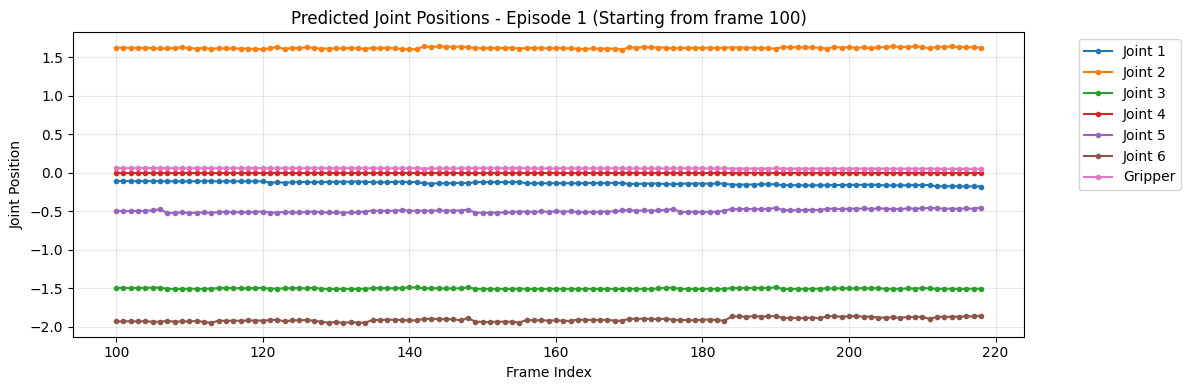

Frames plotted: 101 (from index 100 to 200)


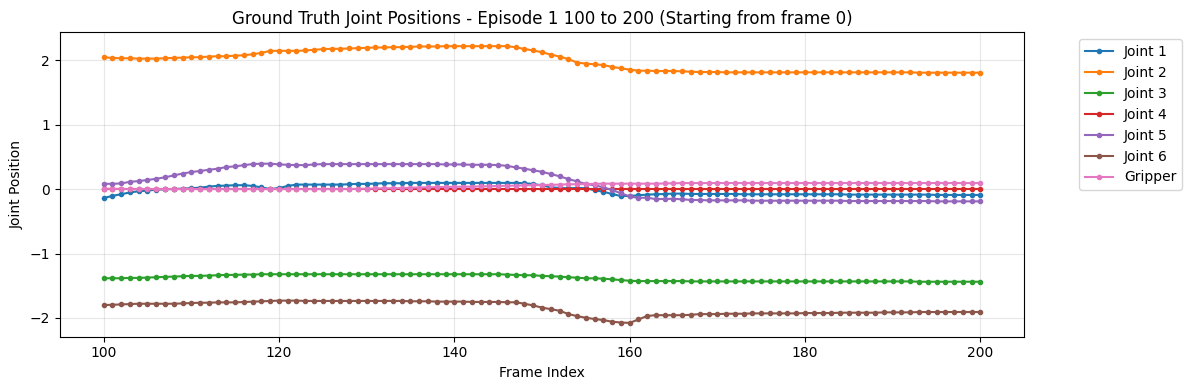

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

import json
import matplotlib.pyplot as plt

def plot_joint_positions(json_file_path, title, start_frame_index=0):
    """
    Plots joint positions from a JSON file, starting from a specified frame index.

    Parameters:
    json_file_path (str): Path to the JSON file.
    title (str): Title for the plot.
    start_frame_index (int): The frame index from which to start plotting. Defaults to 0 (the beginning).
    """
    # Read the JSON file
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Sort data by frame_index
    data.sort(key=lambda x: x['frame_index'])
    
    # Filter data to only include frames from start_frame_index onward
    filtered_data = [item for item in data if item['frame_index'] >= start_frame_index]
    
    if not filtered_data:
        print(f"No data found starting from frame index {start_frame_index}.")
        return
    
    # Extract frame indices and joint positions from the FILTERED data
    frame_indices = [item['frame_index'] for item in filtered_data]
    print(f"Frames plotted: {len(frame_indices)} (from index {min(frame_indices)} to {max(frame_indices)})")
    
    # Initialize lists for each joint
    joints = [[] for _ in range(7)]  # 6 joints + 1 gripper
    
    # Extract joint positions for each frame in the filtered data
    for item in filtered_data:
        action = item['result']['action'][0]  # Get the first (and only) action array
        for i in range(7):  # 6 joints + 1 gripper
            joints[i].append(action[i])
    
    # Create the plot
    plt.figure(figsize=(12, 4)) # Slightly larger figure for clarity
    
    # Joint names
    joint_names = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6', 'Gripper']
    
    # Plot each joint with a different color
    for i in range(7):
        plt.plot(frame_indices, joints[i], label=joint_names[i], marker='o', markersize=3, linewidth=1.5)
    
    # Add labels and title
    plt.xlabel('Frame Index')
    plt.ylabel('Joint Position')
    plt.title(f"{title} (Starting from frame {start_frame_index})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Legend outside plot
    plt.grid(True, alpha=0.3)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


plot_joint_positions('temp/inference_results.json', 'Predicted Joint Positions - Episode 1', start_frame_index=100)
plot_joint_positions('temp/metadata_frames_100_to_200.json', 'Ground Truth Joint Positions - Episode 1 100 to 200')

In [ ]:
from pathlib import Path
from lerobot.policies.diffusion.modeling_diffusion import DiffusionPolicy
output_directory = Path("outputs/eval/example_pusht_diffusion")
# Comment out the old pretrained model path
 # pretrained_policy_path = "lerobot/diffusion_pusht"
# Use your newly trained model path instead
pretrained_policy_path = Path("outputs/train/example_pusht_diffusion")
policy = DiffusionPolicy.from_pretrained("ISdept/piper_arm")